<a href="https://colab.research.google.com/github/SeanMuInCa/learn_python/blob/master/groupassignment2025retry3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install keras-tuner
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import keras_tuner as kt

Train shape: (64000, 35)
Test shape: (16000, 36)
         force_meas         speed  entrytemperature  entrytemperaturebot  \
count  6.400000e+04  64000.000000      64000.000000         64000.000000   
mean   5.003375e+07      3.779013        886.128457           867.350675   
std    1.352541e+07      0.946752         70.285265            65.489190   
min    6.422410e+06      0.110275        667.656567           666.136213   
25%    3.989866e+07      2.999237        835.308614           818.885421   
50%    4.828004e+07      3.703474        878.197080           861.819321   
75%    5.981500e+07      4.485569        931.771724           913.160300   
max    8.911219e+07      6.907368       1151.730368          1086.236252   

       entrytemperaturecore  entrytemperaturetop  entrythickness  \
count          64000.000000         64000.000000    64000.000000   
mean             900.417283           854.123855        0.040993   
std               75.752388            63.090396        0.0267

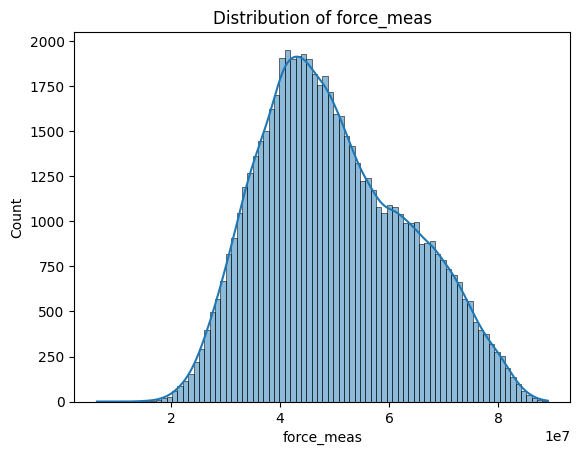

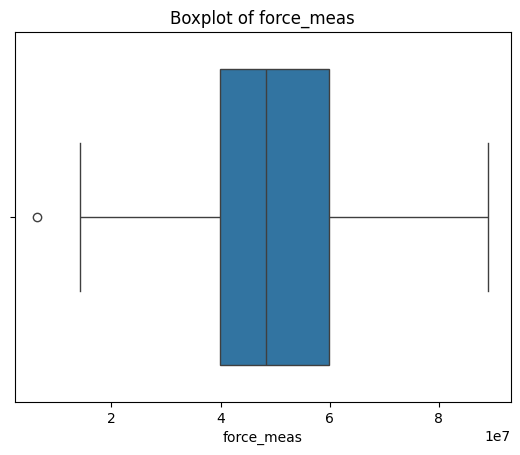

In [14]:
# ----------------------------
# 1. Load & Explore Data
# ----------------------------
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Basic EDA
print("Train shape:", df.shape)
print("Test shape:", df_test.shape)
print(df.describe())
sns.histplot(df['force_meas'], kde=True)
plt.title("Distribution of force_meas")
plt.show()
sns.boxplot(x=df['force_meas'])
plt.title("Boxplot of force_meas")
plt.show()




In [15]:
# ----------------------------
# 2. Split train/val
# ----------------------------
X = df.drop(columns=['force_meas'])
y = df['force_meas'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_test = df_test.drop(columns=['force_meas','force_pre'])
y_test = df_test['force_meas'].values
baseline_pre = df_test['force_pre'].values

In [16]:
# ----------------------------
# 3. One-hot encode
# ----------------------------
def onehot(df_in):
    return pd.get_dummies(df_in, columns=['tappingsteelgrade'], drop_first=True)

X_train = onehot(X_train)
X_val   = onehot(X_val)
X_test  = onehot(X_test)


In [17]:
# ----------------------------
# 4. Align columns
# ----------------------------
cols = X_train.columns.tolist()
with open('training_columns.pkl','wb') as f:
    pickle.dump(cols, f)

X_val  = X_val.reindex(columns=cols, fill_value=0)
X_test = X_test.reindex(columns=cols, fill_value=0)

In [18]:
# ----------------------------
# 5. Scale features
# ----------------------------
scaler = StandardScaler().fit(X_train.values)
X_train_s = scaler.transform(X_train.values)
X_val_s   = scaler.transform(X_val.values)
X_test_s  = scaler.transform(X_test.values)

with open('scaler_dnn_log.pkl','wb') as f:
    pickle.dump(scaler, f)

In [19]:
# ----------------------------
# 6. Log-transform target
# ----------------------------
y_train_log = np.log(y_train)
y_val_log   = np.log(y_val)

In [20]:
# ----------------------------
# 7. Define tuner & model
# ----------------------------
input_dim = X_train_s.shape[1]

def build_model(hp):
    m = keras.Sequential([layers.Input(shape=(input_dim,))])
    for i in range(hp.Int('num_layers',4,6)):
        units = hp.Int(f'units_{i}',32,512,32)
        l2r   = hp.Float(f'l2_{i}',1e-6,1e-3,sampling='LOG')
        m.add(layers.Dense(units, kernel_regularizer=regularizers.l2(l2r)))
        if hp.Choice(f'act_{i}', ['relu','leaky_relu'])=='leaky_relu':
            m.add(layers.LeakyReLU())
        else:
            m.add(layers.Activation('relu'))
        m.add(layers.Dropout(hp.Float(f'drop_{i}',0,0.5,0.1)))
        if hp.Boolean(f'bn_{i}'):
            m.add(layers.BatchNormalization())
    m.add(layers.Dense(1))
    lr = hp.Float('lr',1e-4,1e-2,sampling='LOG')
    m.compile(optimizer=keras.optimizers.Adam(lr), loss='mse', metrics=['mae'])
    return m

tuner = kt.RandomSearch(
    build_model, objective='val_mae', max_trials=30, executions_per_trial=1,
    directory='advanced_dnn_tuning', project_name='rolling_force_final'
)
tuner.search(X_train_s, y_train_log,
             validation_data=(X_val_s, y_val_log),
             epochs=50,
             callbacks=[keras.callbacks.EarlyStopping('val_mae',patience=5)])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best HP:", best_hp.values)


Reloading Tuner from advanced_dnn_tuning/rolling_force_final/tuner0.json
Best HP: {'num_layers': 5, 'units_0': 416, 'l2_0': 9.503714431739539e-05, 'act_0': 'leaky_relu', 'drop_0': 0.1, 'bn_0': True, 'units_1': 480, 'l2_1': 1.363903493315765e-05, 'act_1': 'relu', 'drop_1': 0.1, 'bn_1': False, 'units_2': 512, 'l2_2': 3.394349753223145e-05, 'act_2': 'relu', 'drop_2': 0.1, 'bn_2': False, 'units_3': 512, 'l2_3': 2.4614699315171992e-05, 'act_3': 'leaky_relu', 'drop_3': 0.0, 'bn_3': False, 'lr': 0.00026537414895502884, 'units_4': 256, 'l2_4': 1.7682900458811872e-05, 'act_4': 'relu', 'drop_4': 0.30000000000000004, 'bn_4': True, 'units_5': 480, 'l2_5': 3.218914447637435e-06, 'act_5': 'leaky_relu', 'drop_5': 0.2, 'bn_5': False}


In [21]:
# ----------------------------
# 8. Train final model
# ----------------------------
model = tuner.hypermodel.build(best_hp)
callbacks = [
    keras.callbacks.ReduceLROnPlateau('val_loss',factor=0.5,patience=5,verbose=1),
    keras.callbacks.EarlyStopping('val_loss',patience=10,restore_best_weights=True)
]
model.fit(X_train_s, y_train_log,
          validation_data=(X_val_s, y_val_log),
          epochs=100, batch_size=256,
          callbacks=callbacks)

model.save('optimized_dnn_model_advanced_log.h5')

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 179ms/step - loss: 309.2105 - mae: 17.5501 - val_loss: 282.5793 - val_mae: 16.8052 - learning_rate: 2.6537e-04
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 279.7278 - mae: 16.6878 - val_loss: 250.6778 - val_mae: 15.8174 - learning_rate: 2.6537e-04
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 228.0414 - mae: 15.0368 - val_loss: 171.9040 - val_mae: 13.1009 - learning_rate: 2.6537e-04
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - loss: 163.7787 - mae: 12.6898 - val_loss: 116.1017 - val_mae: 10.7604 - learning_rate: 2.6537e-04
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 101.7979 - mae: 9.9210 - val_loss: 60.4006 - val_mae: 7.7585 - learning_rate: 2.6537e-04
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 53.9892 - mae: 7.1186 - val_loss: 25.4246 - val_mae: 5.0141 - learning_rate: 2.6537e-04
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 24.9427 - mae:

In [22]:
# ----------------------------
# 9. Evaluate on validation set
# ----------------------------
y_val_pred_log = model.predict(X_val_s).flatten()
y_val_pred = np.exp(y_val_pred_log)
val_mae  = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Val MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")

400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Val MAE: 5592616.3620, RMSE: 7231126.4999


In [23]:
# ----------------------------
# 10. Final evaluation on test
# ----------------------------
start = time.time()
y_test_pred_log = model.predict(X_test_s).flatten()
runtime = (time.time() - start) / len(X_test_s)

y_test_pred = np.exp(y_test_pred_log)
mae  = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mse  = mean_squared_error(y_test, y_test_pred)

print(f"\nTest MAE: {mae:.4f}, RMSE: {rmse:.4f}, MSE: {mse:.4f}, time/sample: {runtime:.6f}s")

# Baseline comparison
b_mae  = mean_absolute_error(y_test, baseline_pre)
b_rmse = np.sqrt(mean_squared_error(y_test, baseline_pre))
b_mse  = mean_squared_error(y_test, baseline_pre)
print(f"Baseline MAE: {b_mae:.4f}, RMSE: {b_rmse:.4f}, MSE: {b_mse:.4f}")

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Test MAE: 5507431.6394, RMSE: 7131828.5550, MSE: 50862978537537.1719, time/sample: 0.000163s
Baseline MAE: 2898684.1133, RMSE: 3775600.3207, MSE: 14255157781834.8516
